In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Introduction
This notebook will be helpful,if you would like to create a model and run anyway. I'm begginer (and Japanese).But(Therefore?) codes below can give you first step. The porpose of this notebook is almost minimum modeling, NOT detail EDA and NOT optimizing models.

1. Read .tsv.7z files
2. Min Preprocessiing
3. Text Processing
4. Conversion to sparse type
5. Ridge regression
6. keywords: sparse, tf-idf


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# 1. Read .tsv.7z files

In [ ]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z

In [ ]:
%%time

train_df = pd.read_table('train.tsv')
test_df = pd.read_table('test.tsv')
print(train_df.shape, test_df.shape)

In [ ]:
# 2. Min Preprocessing

2. Min Preprocessing

In [ ]:
# Difine Root Mean Squared Logarithmic Error.
def get_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

RMSLE is calculated as 
 

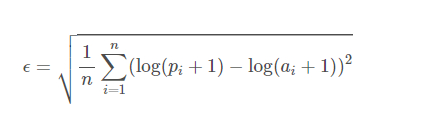

In [ ]:
train_df.head()

In [ ]:
train_df.info()

In [ ]:
test_df.head()

In [ ]:
test_df.info()

In [ ]:
# concat Train and Test data
all_data = pd.concat([train_df, test_df], sort=False)

In [ ]:
all_data.item_condition_id.unique()

In [ ]:
all_data.isnull().sum()

In [ ]:
#"item_description" has 4 NaN, and fill "No description yet"
all_data["item_description"].fillna("No description yet", inplace=True)

#"brand_name" has 928,207 NaN, and fill "None"
all_data["brand_name"].fillna("None", inplace=True)

#"category_name" has 9,385 NaN, and fill "Other"
all_data["category_name"].fillna("Other", inplace=True)

tf-idf vectorizing¶
"name" and "item_description" are written by human freely and difficult to deal with them as Category due to themselve words variety.

You can use "TfidfVectorizer".

In [ ]:
# fit_transform
tfidf_n = TfidfVectorizer()
tfidf_vec_name = tfidf_n.fit_transform(all_data['name'])

tfidf_d = TfidfVectorizer()
tfidf_vec_desc = tfidf_d.fit_transform(all_data['item_description'])

In [ ]:
tfidf_vec_name.shape

In [ ]:
tfidf_vec_desc.shape

In [ ]:
type(tfidf_vec_name)

3. Conversion to sparse type
tf-idf conversion result in csr_matrix type like above. We need convert other columns("item_condition_id", "category_name", "brand_name", "shipping") to csr_matrix with scipy.sparse.csr_matrix

Before conversion them, one-hot encoding is needed.

In the following, each variable is prepared, but there is no problem if you put it in one variable with the for statement. Here, it is written in an easy-to-understand manner using a method called hstack, which will be used later.

In [ ]:
csr_cond = csr_matrix(pd.get_dummies(all_data["item_condition_id"]))
csr_cat_name = csr_matrix(pd.get_dummies(all_data["category_name"]))
csr_brand_name = csr_matrix(pd.get_dummies(all_data["brand_name"]))
csr_ship = csr_matrix(pd.get_dummies(all_data["shipping"]))

In [ ]:
type(csr_cond)

In [ ]:
# Combining sparse explanatory variables with scipy.sparse.hstack
all_data_X = hstack((tfidf_vec_name, tfidf_vec_desc, csr_brand_name, csr_cat_name, csr_cond, csr_ship)).tocsr()

# "price" is target veriable
all_data_y = all_data["price"]

In [ ]:
# split train and test data 
train_X = all_data_X[:len(train_df)]
train_y = all_data_y[:len(train_df)]
test_X = all_data_X[len(train_df):]
print("train_X.shape:", train_X.shape, "\ntest_X.shape:", test_X.shape)

"price" , target veriable log-transformation¶
In good practise, we check this plot at first EDA

In [ ]:
sns.distplot(train_df["price"])

In [ ]:
sns.distplot(np.log1p(train_df["price"]))

In [ ]:
train_y = np.log1p(train_y)

Ridge regression

In [ ]:
# check the validation score
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=2021)

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)
get_rmsle(y_val, y_pred)

**Predict to test data**

In [ ]:
ridge = Ridge()
ridge.fit(train_X, train_y)
test_pred = np.expm1(ridge.predict(test_X)) # Inverse transformation

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub["price"] = test_pred

sub.to_csv("submission.csv", index=False)